Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray

Chapter 5: Classification of Land Cover
=======================================


## Introduction
In this chapter we will classify the Sentinel-2 image we've been working with using a supervised classification approach which incorporates the training data we worked with in [chapter 4](chapter_4_vector.ipynb). Specifically, we will be using the [RandomForest (Brieman 2001)](http://link.springer.com/article/10.1023/A:1010933404324) ensemble decision tree algorithm by [Leo Breiman and Adele Cutler](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm). The RandomForest algorithm has recently become extremely popular in the field of remote sensing, and is quite fast when compared to some other machine learning approaches (e.g., SVM can be quite computationally intensive). This isn't to say that it is the best per se; rather it is a great first step into the world of machine learning for classification and regression.

A few good resources for understanding RandomForest can be found:
+ [Breiman, Leo. 2001. Random Forests. Machine Learning 45-1: 5-32.](http://link.springer.com/article/10.1023/A:1010933404324)
+ [Wikipedia - Random Forest](http://en.wikipedia.org/wiki/Random_forest)
+ [Breiman and Cutler's website](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#workings)
+ [Blog entry from ŷhat](http://blog.yhathq.com/posts/random-forests-in-python.html)

#### Brief Overview of the Algorithm
Rather than utilize the predictions of a single decision tree, the algorithm will take the ensemble result of a large number of decision trees (a forest of them). The "Random" part of the name comes from the term "bootstrap aggregating", or "bagging". What this means is that each tree within the forest only gets to train on some subset of the full training dataset (the subset is determined by sampling with replacement). The elements of the training data for each tree that are left unseen are held "out-of-bag" for estimation of accuracy. Randomness also helps decide which feature input variables are seen at each node in each decision tree. Once all individual trees are fit to the random subset of the training data, using a random set of feature variable at each node, the ensemble of them all is used to give the final prediction. 

In the classification mode, this means that if you were to have 5 classes being predicted using 500 trees, the output prediction would be the class that has the most number of the 500 trees predicting it. The proportion of the number of trees that voted for the winning class can be a diagnostic of the representativeness of your training data relative to the rest of the image. Taking the 500 trees example, if you have pixels which are voted to be in the "Forest" land cover class by 475 of 500 trees, you could say that this was a relatively certain prediction. On the other hand, if you have a pixel which gets 250 votes for "Forest" and 225 votes for "Shrub", you could interpret this as either an innately confusing pixel (maybe it is a mixed pixel, or it is a small statured forest) or as an indicator that you need more training data samples in these types of pixels.

Finally, Random Forest has some other benefits:
+ It gives you a measure of "variable important" which relates how useful your input features (e.g. spectral bands) were in the classification
+ The "out-of-bag" samples in each tree can be used to validate each tree. Grouping these predicted accuracies across all trees can [sometimes give you an unbiased estimate of the error rate](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#ooberr) similar to doing cross-validation.
+ Can be used for regressions, unsupervised clustering, or supervised classification
+ Available in many popular languages, including Python, R, and MATLAB
+ Free and open source, and fast

## scikit-learn

In this chapter we will be using the Random Forest implementation provided by the [scikit-learn](http://scikit-learn.org) library. `scikit-learn` is an amazing machine learning library that provides easy and consistent interfaces to many of the most popular machine learning algorithms. It is built on top of the pre-existing scientific Python libraries, including `numpy`, `scipy`, and `matplotlib`, which makes it very easy to incorporate into your workflow. The number of available methods for accomplishing any task contained within the library is (in my opinion) its real strength. No single algorithm is best for all tasks under all circumstances, and `scikit-learn` helps you understand this by abstracting the details of each algorithm to simple consistent interfaces. For example:

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png" alt="An Iris" style="width: 800px;"/>

[This figure](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) shows the classification predictions and the decision surfaces produced for three classification problems using 9 different classifiers. What is even more impressive is that all of this took only about 110 lines of code, including comments!

## Preparing the dataset
#### Opening the images
Our first step is to recall our previous chapter's lessons and import the things we'll need:

In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping

Now we need to collect all the Sentinal-2 bands because they come as individual images one per band.

In [2]:
import os # we need os to do some basic file operations

sentinal_fp = "../data/sentinel-2/"
# find every file in the sentinal_fp directory
sentinal_band_paths = [os.path.join(sentinal_fp, f) for f in os.listdir(sentinal_fp) if os.path.isfile(os.path.join(sentinal_fp, f))]

Now we need a rasterio dataset object containing all bands in order to use the mask() function and extract pixel values using geospatial polygons.

We'll do this by creating a new raster dataset and saving it for future uses.

In [4]:
# create a products directory within the data dir which won't be uploaded to Github
img_dir = '../data/products/'

# check to see if the dir it exists, if not, create it
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# filepath for image we're writing out
img_fp = img_dir + 'sentinel_bands.tif'

# Read metadata of first file and assume all other bands are the same
with rasterio.open(sentinal_band_paths[0]) as src0:
    meta = src0.meta

# Update metadata to reflect the number of layers
meta.update(count = len(sentinal_band_paths))

# Read each layer and write it to stack
with rasterio.open(img_fp, 'w', **meta) as dst:
    for id, layer in enumerate(sentinal_band_paths, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

Okay we've successfully written it out now let's open it back up and make sure it meets our expectations:

In [5]:
full_dataset = rasterio.open(img_fp)
img_rows, img_cols = full_dataset.shape
img_bands = full_dataset.count
print(full_dataset.shape) # dimensions
print(full_dataset.count) # bands

(2201, 2629)
8


Let's clip the image and take a look where we know the training data was from the last lesson (on the NC Rachel Carson Reserve) just to make sure it looks normal:

(3, 450, 1150)


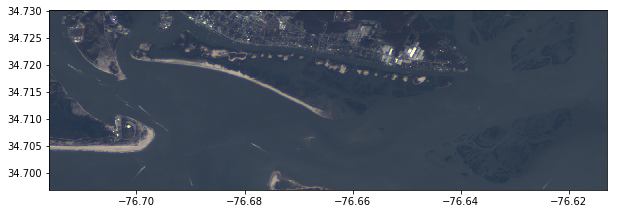

In [8]:
import matplotlib.pyplot as plt
from rasterio.plot import show

clipped_img = full_dataset.read([3,2,1])[:, 150:600, 250:1400]
print(clipped_img.shape)
fig, ax = plt.subplots(figsize=(10,7))
show(clipped_img[:, :, :], ax=ax, transform=full_dataset.transform) # add the transform arg to get it in lat long coords

Okay looks good! Our raster dataset is ready!

### Now our goal is to get the pixels from the raster as outlined in each shapefile. 

Our training data, the shapefile we've worked with, contains one main field we care about:
+ a Classname field (String datatype)

Combined with the innate location information of polygons in a Shapefile, we have all that we need to use for pairing labels with the information in our raster.

However, in order to pair up our vector data with our raster pixels, we will need a way of co-aligning the datasets in space. 

We'll do this using the rasterio mask function which takes in a dataset and a polygon and then outputs a numpy array with the pixels in the polygon.

Let's run through an example:

In [9]:
full_dataset.crs

CRS({'init': 'epsg:4326'})

Open up our shapefile and check its crs

In [10]:
shapefile = gpd.read_file('../data/rcr/rcr_landcover.shp')
shapefile.crs

{'init': 'epsg:32618'}

Remember the projections don't match! Let's use some geopandas magic to reproject all our shapefiles to lat, long.

In [11]:
shapefile = shapefile.to_crs({'init': 'epsg:4326'})
# or shapefile.to_crs(epsg:4326) would also work

In [12]:
shapefile.crs

{'init': 'epsg:4326'}

Now we want to extract the geometry of each feature in the shapefile in GeoJSON format:

In [13]:
# this generates a list of shapely geometries
geoms = shapefile.geometry.values 

# let's grab a single shapely geometry to check
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((-76.65445610974965 34.7054574844727, -76.65457138511347 34.70531784849001, -76.6550917986076 34.70555019272821, -76.65485683506891 34.70568982255048, -76.65445610974965 34.7054574844727))
<class 'list'>
[{'type': 'Polygon', 'coordinates': (((-76.65445610974965, 34.705457484472696), (-76.65457138511347, 34.70531784849001), (-76.6550917986076, 34.70555019272821), (-76.65485683506891, 34.705689822550475), (-76.65445610974965, 34.705457484472696)),)}]


Now let's extract the raster values values within the polygon using the rasterio [mask() function](https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html)

In [14]:
out_image, out_transform = mask(full_dataset, feature, crop=True)
out_image.shape

(8, 6, 8)

Okay those looks like the right dimensions for our training data. 8 bands and 6x8 pixels seems reasonable given our earlier explorations.

We'll be doing a lot of memory intensive work so let's clean up and close this dataset.

In [15]:
full_dataset.close()

### Building the Training Data for `scikit-learn`

Now let's do it for all features in the shapefile and create an array `X` that has all the pixels and an array `y` that has all the training labels.

In [16]:
X = np.array([], dtype=np.int8).reshape(0,8) # pixels for training
y = np.array([], dtype=np.string_) # labels for training

# extract the raster values within the polygon 
with rasterio.open(img_fp) as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True) 
        # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[shapefile["Classname"][index]] * out_image_reshaped.shape[0]) 
        # stack the pizels onto the pixel array
        X = np.vstack((X,out_image_reshaped))        

#### Pairing Y with X
Now that we have the image we want to classify (our X feature inputs), and the land cover labels (our y labeled data), let's check to make sure they match in size so we can feed them to Random Forest:

In [17]:
# What are our classification labels?
labels = np.unique(shapefile["Classname"])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
                                                                classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

The training data include 7 classes: ['Emergent Wetland' 'Forested Wetland' 'Herbaceous' 'Sand'
 'Scrub-Shrub Wetland' 'Subtidal Haline' 'WetSand']

Our X matrix is sized: (887, 8)
Our y array is sized: (887,)


It all looks good! Let's explore the spectral signatures of each class now to make sure they're actually separable since all we're going by in this classification is pixel values.

Text(0.5, 1.0, 'Band Intensities Higher Ref Subset')

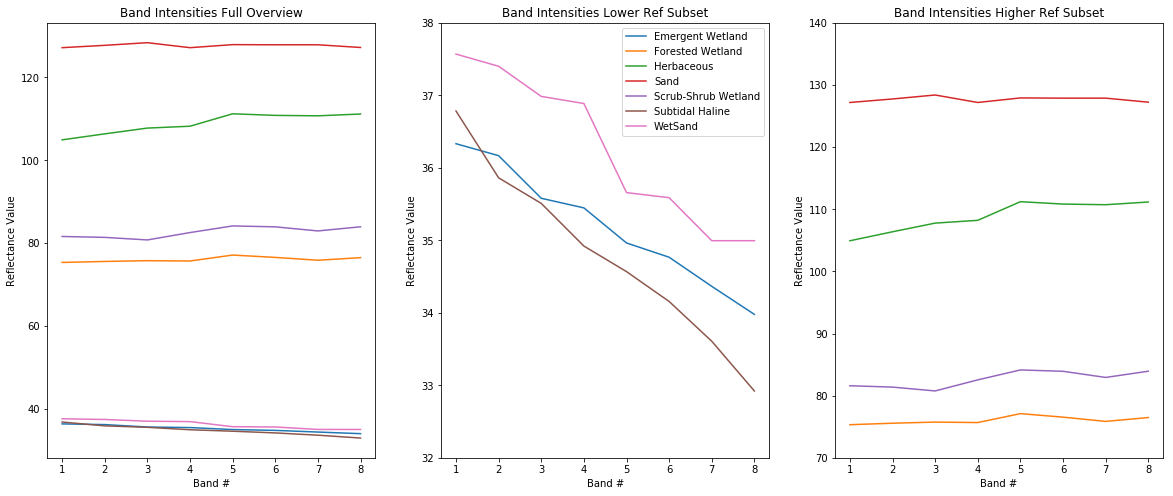

In [18]:
fig, ax = plt.subplots(1,3, figsize=[20,8])

# numbers 1-8
band_count = np.arange(1,9)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=class_type)
    ax[1].plot(band_count, band_intensity, label=class_type)
    ax[2].plot(band_count, band_intensity, label=class_type)
# plot them as lines

# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
ax[1].set_ylabel('Reflectance Value')
ax[1].set_xlabel('Band #')
ax[2].set_ylabel('Reflectance Value')
ax[2].set_xlabel('Band #')
#ax[0].set_ylim(32,38)
ax[1].set_ylim(32,38)
ax[2].set_ylim(70,140)
#ax.set
ax[1].legend(loc="upper right")
# Add a title
ax[0].set_title('Band Intensities Full Overview')
ax[1].set_title('Band Intensities Lower Ref Subset')
ax[2].set_title('Band Intensities Higher Ref Subset')


They look okay but emergent wetland, water, and wet sand look quite similar! They're going to be difficult to differentiate.

## Training the Random Forest
Now that we have our X matrix of feature inputs (the spectral bands) and our y array (the labels), we can train our model.

Visit [this web page to find the usage of RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from `scikit-learn`.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

#### Random Forest diagnostics

With our Random Forest model fit, we can check out the "Out-of-Bag" (OOB) prediction score:

In [20]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 57.384441939120634%


To help us get an idea of which spectral bands were important, we can look at the feature importance scores:

In [21]:
bands = [1, 2, 3, 4, 5, 7, 7, 8]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.12194042898231619
Band 2 importance: 0.11915929218497172
Band 3 importance: 0.1264672836873601
Band 4 importance: 0.12166524957512916
Band 5 importance: 0.12761779585485822
Band 7 importance: 0.12675326088509803
Band 7 importance: 0.12032280632990573
Band 8 importance: 0.13607388250036107


Not a huge difference among bands... but as usually NIR (band 8) looks to be pretty informative.

Let's look at a crosstabulation to see the class confusion. To do so, we will import the [Pandas](http://pandas.pydata.org/) library for some help:

In [22]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict              Emergent Wetland  Forested Wetland  Herbaceous  Sand  \
truth                                                                       
Emergent Wetland                  270                 0           0     0   
Forested Wetland                    0                92           0     0   
Herbaceous                          0                 0          76     0   
Sand                                0                 0           0    82   
Scrub-Shrub Wetland                 0                 0           0     0   
Subtidal Haline                     2                 0           0     0   
WetSand                             2                 0           0     0   
All                               274                92          76    82   

predict              Scrub-Shrub Wetland  Subtidal Haline  WetSand  All  
truth                                                                    
Emergent Wetland                       0                3        6  279  
Foreste

Unbelievable, eh? I highly doubt the real confusion matrix will be 100% accuracy. What is likely going on is that we used a large number of trees within a machine learning algorithm to best figure out the pattern in our training data. Given enough information and effort, this algorithm precisely learned what we gave it. Asking to validate a machine learning algorithm on the training data is a useless exercise that will overinflate the accuracy.

Instead, we could have done a crossvalidation approach where we train on a subset the dataset, and then predict and assess the accuracy using the sections we didn't train it on. To get a robust measure of the performance, we would run this using random subsets some number of times.

## Predicting the rest of the image

With our Random Forest classifier fit, we can now proceed by trying to classify the entire image:

We're only going to open the subset of the image we viewed above because otherwise it is computationally too intensive for most users.

In [23]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

In [24]:
with rasterio.open(img_fp) as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read()[:, 150:600, 250:1400]

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

(8, 450, 1150)
(450, 1150, 8)


### Finally! Now we can predict for each pixel in our image:

In [34]:
class_prediction = rf.predict(reshaped_img.reshape(-1, 8))

# Reshape our classification map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

Because our shapefile came with the labels as strings we want to convert them to a numpy array with ints.

In [35]:
class_prediction[class_prediction == 'Subtidal Haline'] = 0
class_prediction[class_prediction == 'WetSand'] = 1
class_prediction[class_prediction == 'Emergent Wetland'] = 2
class_prediction[class_prediction == 'Sand'] = 3
class_prediction[class_prediction == 'Herbaceous'] = 4
class_prediction[class_prediction == 'Scrub-Shrub Wetland'] = 5
class_prediction[class_prediction == 'Forested Wetland'] = 6

class_prediction = class_prediction.astype(int)

### Let's visualize it!

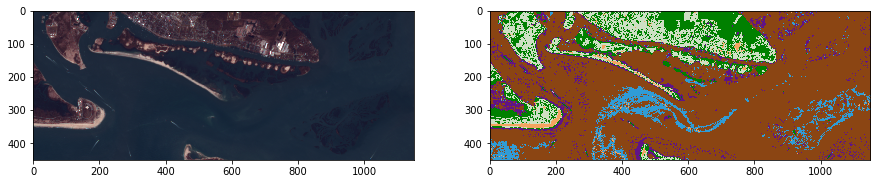

In [36]:
# First setup a 5-4-3 composite
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (1, (48, 156, 214, 255)),   # Blue - Water
    (2, (139,69,19, 255)),      # Brown - WetSand
    (3, (96, 19, 134, 255)),    # Purple - Emergent Wetland
    (4, (244, 164, 96, 255)),   # Tan - Sand
    (5, (206, 224, 196, 255)),      # Lime - Herbaceous
    (6, (0, 128, 0, 255)),      # Regular Green - Scrub-Shrub
    (7, (34, 139, 34, 255)),    # Forest Green - Forest 
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the class map next to the RGB image

fig, axs = plt.subplots(1,2,figsize=(15,15))

img_stretched = color_stretch(reshaped_img, [4, 2, 1])
axs[0].imshow(img_stretched)

axs[1].imshow(class_prediction, cmap=cmap, interpolation='none')

plt.show()

### Not the worst... but it doesn't look amazing.

The water isn't being classified correctly. Let's see if we can fix that with the Normalized Difference Water Index (NDWI). NDWI is similar to NDVI but for identifying water.

In [41]:
with rasterio.open(img_fp) as src:
    green_band = src.read(3)
    nir_band = src.read(8)
    
ndwi = (green_band.astype(float) - nir_band.astype(float)) / (green_band.astype(float) + nir_band.astype(float))

print('\nMax NDWI: {m}'.format(m=ndwi.max()))
print('Mean NDWI: {m}'.format(m=ndwi.mean()))
print('Median NDWI: {m}'.format(m=np.median(ndwi)))
print('Min NDWI: {m}'.format(m=ndwi.min()))


Max NDWI: 0.76
Mean NDWI: 0.3475598367101243
Median NDWI: 0.59375
Min NDWI: -0.6494845360824743


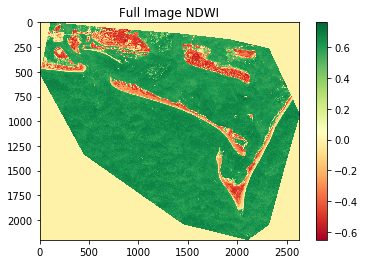

In [42]:
fig, ax = plt.subplots()
nwdi_plot = ax.imshow(ndwi, cmap="RdYlGn")
ax.set_title("Full Image NDWI")
fig.colorbar(nwdi_plot, ax=ax)

In [43]:
ndwi = ndwi[150:600, 250:1400]

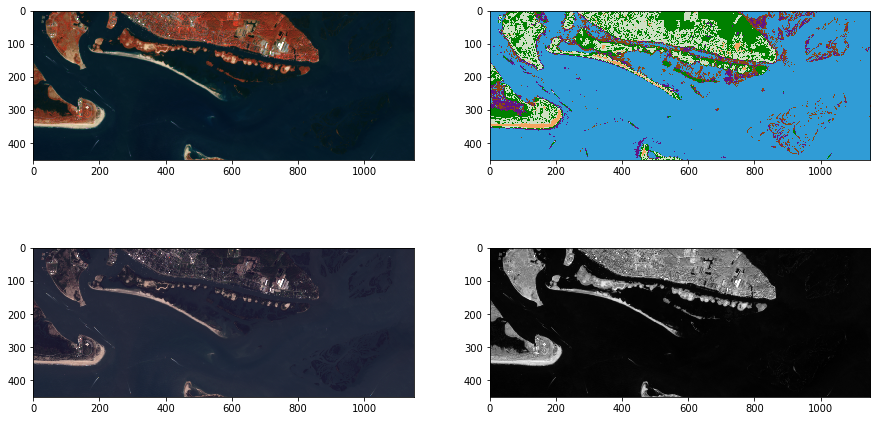

In [47]:
# Now show the classmap next to the image
fig, axs = plt.subplots(2,2,figsize=(15,8))

img_stretched = color_stretch(reshaped_img, [7, 4, 2])
axs[0,0].imshow(img_stretched)

# try changing this threshold to see what threshold works best
class_prediction[ndwi > 0.55] = 0

axs[0,1].imshow(class_prediction, cmap=cmap, interpolation='none')

img_stretched = color_stretch(reshaped_img, [3, 2, 1])
axs[1,0].imshow(img_stretched)

img_stretched = color_stretch(reshaped_img, [7, 7, 7])
axs[1,1].imshow(img_stretched)

plt.show()

#### Now this helps a good bit! 

Part of the issue in this environment is that the water near the inlet has very different spectral properties than shallow water or particulate laden brackish water. And our training data doesn't encompass all those types and so it confuses intertidal sand with water.

Let's take a closer look at the Duke Marine Lab and the tip of the Rachel Carson Reserve.

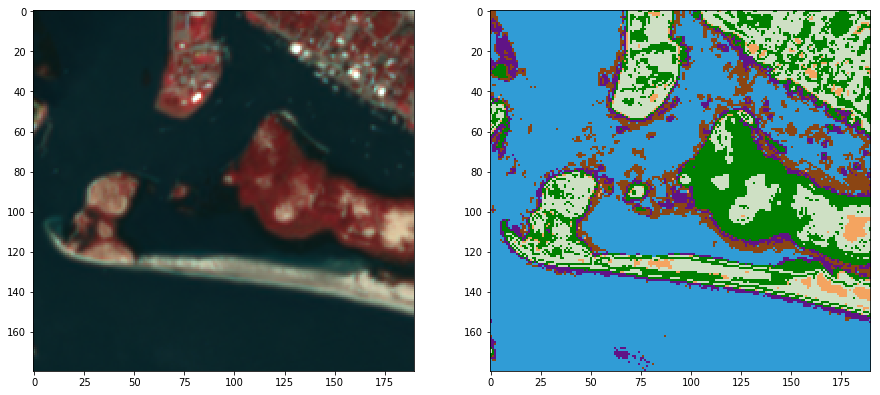

In [56]:
fig, axs = plt.subplots(1,2,figsize=(15,15))

img_stretched = color_stretch(reshaped_img, [5, 3, 2])
axs[0].imshow(img_stretched[0:180, 160:350])

axs[1].imshow(class_prediction[0:180, 160:350], cmap=cmap, interpolation='none')

plt.show()

This actually doesn't look half bad! Land cover mapping is a complex problem and one where there are many approaches and tools for improving a map.

## Testing an Unsupervised Classification Algorithm

Let's also try a unsupervised classification algorithm, k-means clustering, in the scikit-learn library ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html))

K-means ([wikipedia page](https://en.wikipedia.org/wiki/K-means_clustering)) aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster.

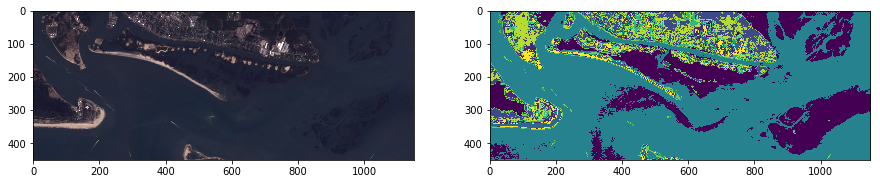

In [57]:
from sklearn.cluster import KMeans

bands, rows, cols = img.shape

k = 10 # num of clusters

kmeans_predictions = KMeans(n_clusters=k, random_state=0).fit(reshaped_img.reshape(-1, 8))

kmeans_predictions_2d = kmeans_predictions.labels_.reshape(rows, cols)

# Now show the classmap next to the image
fig, axs = plt.subplots(1,2,figsize=(15,8))

img_stretched = color_stretch(reshaped_img, [3, 2, 1])
axs[0].imshow(img_stretched)

axs[1].imshow(kmeans_predictions_2d)

Wow this looks better than our supervised classification approach! But supervised usually does better with some tuning, luckily there are lots of ways to think about improving our supervised method.

## Wrapup

We've seen how we can use `scikit-learn` to implement the Random Forest classifier for land cover classification. A couple future directions that immediately follow this tutorial include:

+ Extend the lessons learned in the [visualization chapter](chapter_3_visualization.ipynb) to explore the class separability along various dimensions of the data. For example, plot bands against each other and label each point in the scatter plot a different color according to the training data label.
+ Add additional features - would using NDVI as well as the spectral bands improve our classification?
+ `scikit-learn` includes many machine learning classifiers -- are any of these better than Random Forest for our goal? SVM? Nearest Neighbors? Others?
+ In this example we only use 8-bit imagery, 16 or 32 bit may contain more information that helps distinguish the classes
+ Our training data was created using ultra-high resolution drone imagery. A good deal of error could be coming from the fact that the training samples don't line up exactly with the classes in this imagery. Editing the training shapefile to be better matched to this image could lead to a major improvement.
+ This approach only leverages the spectral information in Landsat. What would happen if we looked into some spatial information metrics like incorporating moving window statistics? For more on this, see [chapter 6](chapter_6_spatial.ipynb).
+ And while more advanced deep learning methods could lead to major improvements in this classification!

### Quantative Accuracy Assessments!
We've seen how Random Forest can come up with an estimate of the classification accuracy using the "Out-of-Bag" samples. While this may be a useful metric, we will need to perform a proper accuracy assessment based on a probability sample to conclude anything about the accuracy of the entire area. With the information from the accuracy assessment, we will be able not only to tell how good the map is, but more importantly we will be able to come up with statistically defensible unbiased estimates with confidence intervals of the land cover class areas in the map. For more information, see [Olofsson, *et. al.*, 2013](http://www.sciencedirect.com/science/article/pii/S0034425712004191).

## Next Steps

I'm planning on adding some more topic specific notebooks in the future and would love if anyone wants to add their own either field specific tutorial (hydrology, oceanography, forestry, urban development, etc) or tutorials for more advanced tools!

In the meantime I would recommend the following:
- follow some top research journals such as https://www.journals.elsevier.com/remote-sensing-of-environment
- explore other good notebooks and tutorials like https://github.com/planetlabs/notebooks
- play with all the amazing datasets out there (e.g. Earth on AWS https://aws.amazon.com/earth/)
- self-teach all the other cool open source python geospatial tools: https://github.com/sacridini/Awesome-Geospatial#python 
